In [1]:
import h5py
import numpy as np
import matplotlib.pyplot as plt

# Specify the case and directory
icase = 1  # 1=BLdns1 | 2=BLdns2
DIR = 'data'  # folder with the data

# Load file paths
file_means = f'{DIR}/BLdns{icase}_means.h5'
file_grid = f'{DIR}/BLdns{icase}_grid.h5'
file_parameters = f'{DIR}/BLdns{icase}_parameters.h5'
file_planes = f'{DIR}/BLdns{icase}_planes.h5'

# Read parameters and data
with h5py.File(file_parameters, 'r') as f:
    Uinf = np.array(f['/Uinf'])
    nu = np.array(f['/nu'])
    Lo = np.array(f['/Lo'])

# Read Cf and Retheta
with h5py.File(file_means, 'r') as f:
    Cf = np.array(f['/Cf'])
    Retheta = np.array(f['/Retheta'])

In [2]:
with h5py.File(file_grid, 'r') as f:
    y = np.array(f['/y'])

with h5py.File(file_means, 'r') as f:
    Umean = np.array(f['/Umean'])
    urms = np.array(f['/urms'])
    vrms = np.array(f['/vrms'])
    wrms = np.array(f['/wrms'])
    Retau = np.array(f['/Retau'])
    utau = np.array(f['/utau'])
    delta99 = np.array(f['/delta99'])


In [3]:
with h5py.File(file_planes, 'r') as f:
    Uplane = np.array(f['/Uplane'])

with h5py.File(file_grid, 'r') as f:
    x = np.array(f['/x'])
    y = np.array(f['/y'])

with h5py.File(file_parameters, 'r') as f:
    time = np.array(f['/time'])
    Uinf = np.array(f['/Uinf'])
    Lo = np.array(f['/Lo'])
Uplane = np.transpose(Uplane, (2, 1, 0))

In [4]:
x    = np.squeeze(x)
y    = np.squeeze(y)
X, Y = np.meshgrid(x / Lo, y / Lo)
X    = X.T  # Transpose X to match Uplane dimensions
Y    = Y.T  # Transpose Y to match Uplane dimensions
dt   = time[1]-time[0]

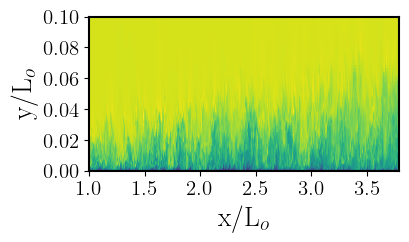

In [25]:
tref = 1000  # arbitrary time = time(tref)
plt.figure(figsize=(4, 2))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering
plt.pcolor(X,Y, np.squeeze(Uplane[tref, :, :]) / Uinf, shading='auto')
plt.xlabel(r'x/L$_o$', fontsize=20)
plt.ylabel(r'y/L$_o$', fontsize=20)
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)
plt.axis('equal')
plt.axis('tight')
plt.ylim([0,0.10])
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.savefig('BL_inst.png', dpi=300,bbox_inches='tight') 
plt.savefig('BL_inst.eps', dpi=300,bbox_inches='tight') 

plt.show()


In [6]:
def MI_d_binning(input, output, num_bins):
    #Calculate the mutual information between two matrices X and Y using histograms.
    #Fast! But not Accurate! Using it for approximation.
    #Parameters:
    #X (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #Y (numpy.ndarray): A matrix with shape (num_samples, num_dimensions)
    #num_bins (int): Number of bins for the histogram
    #Returns:
    #float: The mutual information between X and Y.
    def entropy_bin(X, num_bins):
        N, D = X.shape
        bins = [num_bins] * D
        hist, _ = np.histogramdd(X, bins=bins)
        hist = hist / np.sum(hist)  # Normalize to get probabilities
        positive_indices = hist > 0
        return -np.sum(hist[positive_indices] * np.log(hist[positive_indices]))

    mi = entropy_bin(input, num_bins) + entropy_bin(output, num_bins) - entropy_bin(np.hstack([input, output]), num_bins)
    return mi

def KraskovMI1_nats( x, y, k : int = 1 ):
    '''Compute the mutual information using the Kraskov estimator (approach
    1 in Kraskov et al. (2004))
    Parameters
        x:  np.ndarray
            [ N, dim_x ] First variable of dimension "dim_x" with "N" samples
            per dimension
        y:  np.ndarray
            [ N, dim_x ] second variable of dimension "dim_x" with "N" samples
            per dimension
        
        k:  int
            Nearest-neighbor ( >= 1 )
    '''

    N, dim = x.shape

    V = np.hstack([ x, y ])

    # Init query tree
    kdtree = scispa.KDTree( V )
    ei, _ = kdtree.query( V, k + 1, p = np.infty)
    # infty norm is gonna give us the maximum distance (x-dir or y-dir)
    dM = ei[:,-1]

    kdtree_x = scispa.KDTree( x )
    kdtree_y = scispa.KDTree( y )

    nx = kdtree_x.query_ball_point( x, dM , p = np.infty, return_length = True)
    ny = kdtree_y.query_ball_point( y, dM , p = np.infty, return_length = True)

    # we do not add + 1 because it is accounted in query_ball_point
    ave = ( scis.psi( nx ) + scis.psi( ny ) ).mean()

    return scis.psi(k) - ave + scis.psi(N)

In [9]:
import numpy as np
import scipy.spatial as scispa
import scipy.special as scis

# Get the dimensions of Uplane
Nt, Nx, Ny = Uplane.shape
print('Nt,Nx,Ny',Nt,Nx,Ny)

i_values = list(range(1,1000,40))  # Replace with your desired range or a single value for i
j_values = list(range(2,30,2))
#j_values = [5,10,20,30]
# Initialize the input matrix and output vector as lists
input_matrix = []
output_vector = []
label_vector = []
label_counter = 0  # Start counter at 0

delta_t_values = list(range(1, 10))  # This will generate [1, 2, 3]
#delta_t_valyes = 20
for delta_t in delta_t_values:  # Loop through different delta_t values
    true_time_difference = delta_t * dt  # Calculate the true time difference
    for i in i_values:
        for j in j_values:
            utau_value  = utau[i].item()
            U0    = np.array([Uplane[:-delta_t, i, j]]).reshape(-1,1)
            Uplus = np.array(Uplane[ delta_t:, i, j]).reshape(-1,1)
            U0_normalized = U0 / utau_value
            Uplus_normalized = Uplus / utau_value
            input_vector = np.array([ nu.item() , x[i], y[j] , utau_value ,  delta_t*dt.item() ]) 
            #MI  = MI_d_binning(U0_normalized,Uplus_normalized,50)
            MI  = KraskovMI1_nats(U0_normalized,Uplus_normalized,8)

            output = np.exp(-MI)
            input_matrix.append(input_vector)
            output_vector.append(output)
            label = i * 1000 + j  # This combines i and j into a single unique label
            label_vector.append(label)

# Convert the lists to NumPy arrays
input_matrix = np.array(input_matrix)
output_vector = np.array(output_vector)


Nt,Nx,Ny 10000 2049 180


In [10]:
p  = input_matrix
q = output_vector

print(p.shape)
label_vector = np.array(label_vector)
print('label_vector.size',label_vector.size)

(3150, 5)
label_vector.size 3150


In [11]:
from numpy.linalg import matrix_rank, inv
from pprint import pprint
from scipy.linalg import null_space

D_in = np.matrix(' 2 1 1  1  0;   -1 0 0   -1 1  ')
print("Rank of D_in:", matrix_rank(D_in))
print("D_in matrix:\n", D_in)
num_rows   = np.shape(D_in)[0]
num_cols   = np.shape(D_in)[1]
# Function to calculate basis matrices
def calc_basis(D_in, col_range):
    num_rows   = np.shape(D_in)[0]
    num_cols   = np.shape(D_in)[1]
    Din1, Din2 = D_in[:, :num_rows], D_in[:, num_rows:]
    basis_matrices = []
    for i in range(col_range):
        x2 = np.zeros((col_range, 1))
        x2[i, 0] = -1
        x1 = -inv(Din1) * Din2 * x2
        basis_matrices.append(np.vstack((x1, x2)))
    return np.asmatrix(np.array(basis_matrices))

# Generate basis matrices
num_basis = D_in.shape[1] - matrix_rank(D_in)
basis_matrices = calc_basis(D_in,num_basis)
basis_matrices = -basis_matrices

print("Basis vectors from null space:")
print(basis_matrices)

Rank of D_in: 2
D_in matrix:
 [[ 2  1  1  1  0]
 [-1  0  0 -1  1]]
Basis vectors from null space:
[[-0. -1.  1. -0. -0.]
 [-1.  1. -0.  1. -0.]
 [ 1. -2. -0. -0.  1.]]


In [12]:
def calc_pi(a, basis_matrices,X):
    coef_pi = np.dot(a, basis_matrices)  # Computes the weighted sum of basis matrices
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
    return pi_mat


def calc_pi_omega(coef_pi, X):
    pi_mat = np.ones((X.shape[0], 1))
    for i in range(coef_pi.shape[1]):
        tmp = X[:, i] ** coef_pi[:, i]
        pi_mat = np.multiply(pi_mat, tmp.reshape(-1, 1))
        
    return pi_mat

In [13]:
def MI_input_output(para,basis_matrices,X,Y,num_basis,num_inputs):
    with warnings.catch_warnings():
        warnings.filterwarnings('error')  # Treat warnings as errors
        a_list = [tuple(para[i*num_basis:(i+1)*num_basis]) for i in range(num_inputs)]
        try:
            pi_list = [calc_pi(a, basis_matrices, X) for a in a_list]
            pi = np.column_stack(pi_list)
        except RuntimeWarning:
            return random.uniform(1e6, 1e10)  # Return a large positive value in case of RuntimeWarning
    
    if np.any(np.isnan(pi)):
        return random.uniform(1e6, 1e10)  # Return a large positive value
    
    Y = Y.reshape(-1, 1)
    MI = MI_d_binning(np.array(pi), np.array(Y), 40)
    #MI = KraskovMI1_nats(np.array(pi), np.array(Y), 5)

    return -MI

In [14]:
import cma
import warnings
import random
import scipy.special as scis
import scipy.spatial as scispa

from cma import CMAEvolutionStrategy
num_input = num_cols - num_rows
num_input = 1
num_para = num_basis*num_input
print('num of paraters:',num_para)
lower_bounds = [-2] * num_para  # Replace -5 with your actual lower bound
upper_bounds = [2] * num_para   # Replace 5 with your actual upper bound
bounds = [lower_bounds, upper_bounds]
options = {
    'bounds': bounds,
    'maxiter': 100,  # maximum number of iterations
    'tolx': 1e-4,     # tolerance in solution variability
    'tolfun': 1e-4,   # tolerance in function value changes
    'popsize': 100,

    # ... other options ...
}
es = CMAEvolutionStrategy([0.1] * num_para, 0.5,options)
while not es.stop():
    solutions = es.ask()
    es.tell(solutions, [MI_input_output(x,basis_matrices,p,q,num_basis,num_input) for x in solutions])
    es.disp()
es.result_pretty()
optimized_params = es.result.xbest
optimized_MI     = es.result.fbest
print('Optimized_params',optimized_params)
print('Optimized_MI',optimized_MI)

num of paraters: 3
(50_w,100)-aCMA-ES (mu_w=27.0,w_1=8%) in dimension 3 (seed=774007, Mon Nov  4 10:49:54 2024)
Iterat #Fevals   function value  axis ratio  sigma  min&max std  t[m:s]
    1    100 -1.491654588187750e+00 1.0e+00 4.49e-01  3e-01  6e-01 0:00.1
    2    200 -1.197652976354647e+00 3.1e+00 4.90e-01  2e-01  8e-01 0:00.2
    3    300 -1.540591472544158e+00 7.1e+00 6.03e-01  1e-01  1e+00 0:00.2
   50   5000 -1.904973800890985e+00 8.9e+01 9.17e+00  1e-05  3e-04 0:03.3
   55   5500 -1.904973800890985e+00 1.9e+02 1.32e+01  4e-06  9e-05 0:03.6
termination on tolx=0.0001
final/bestever f-value = -1.904974e+00 -1.905145e+00 after 5500/5284 evaluations
incumbent solution: [0.02727037178426415, 0.44404362958053284, 0.19825398154861576]
std deviation: [3.68429938394915e-06, 8.666840840536552e-05, 3.3113537705320014e-05]
Optimized_params [0.02726722 0.44424401 0.19832913]
Optimized_MI -1.9051454582472998


In [15]:
a_list = [tuple(optimized_params[i*num_basis:(i+1)*num_basis]) for i in range(num_input)]
#print('a_list:',a_list)
# Step 1: Compute coef_pi for each a in a_list
coef_pi_list = [np.dot(a, basis_matrices) for a in a_list]

# Step 2 & 3: Normalize each coef_pi by its own smallest absolute value
normalized_coef_pi_list = []
for coef_pi in coef_pi_list:
    max_abs_value = np.max(np.abs(coef_pi))
    normalized_coef_pi = coef_pi / max_abs_value*2
    normalized_coef_pi_list.append(np.round(normalized_coef_pi,0))

# Print the normalized coef_pi values
for i, normalized_coef_pi in enumerate(normalized_coef_pi_list):
    print(f'coef_pi{i+1}', normalized_coef_pi)

coef_pi1 [[-1.  0.  0.  2.  1.]]


In [16]:
import numpy as np
variables_p = ['\\nu','x', 'y','u_{\\tau}','\Delta t'];
#variables_p = ['U(t)','x', 'y','\\nu','u_{\\tau}'];
# Initialize labels

omega_p = np.array(normalized_coef_pi_list)
omega_p = np.array(omega_p).reshape(-1, len(variables_p))

def create_labels(omega, variables):
    labels = []
    for row in omega:
        positive_part = ''
        negative_part = ''
        for i, value in enumerate(row):
            value = np.round(value,2)
            if value > 0:
                if positive_part == '':
                    positive_part = f"{variables[i]}^{{{value}}}"
                else:
                    positive_part += f" \\cdot {variables[i]}^{{{value}}}"
            elif value < 0:
                if negative_part == '':
                    negative_part = f"{variables[i]}^{{{-value}}}"
                else:
                    negative_part += f" \\cdot {variables[i]}^{{{-value}}}"
        if negative_part == '':
            labels.append(f"${positive_part}$")
        elif positive_part == '':
            labels.append(f"$\\frac{{1}}{{{negative_part}}}$")
        else:
            labels.append(f"$\\frac{{{positive_part}}}{{{negative_part}}}$")
    return labels

p_lab = create_labels(omega_p, variables_p)
# Print the labels
from IPython.display import Math, display
for j, label in enumerate(p_lab):
    #print(f'Pi_q_lab[{j}] = {label}')
    print(f'Pi_q_lab[{j}]=') 
    display(Math( label ))
    

Pi_q_lab[0]=


<IPython.core.display.Math object>

In [17]:
MI_input_output(x,basis_matrices,p,q,num_basis,num_input)

-0.4270872854974863

In [18]:
y    = p[:, 1]
nu   = p[:, 2]
utau = p[:, 3]
dt   = p[:, 4]
Pi_t_p=dt*utau/y

3150


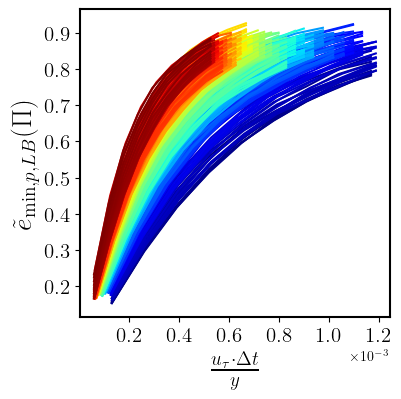

In [19]:
# Generate a color map for the labels
import matplotlib.ticker as ticker

y      = p[:, 1]
nu     = p[:, 2]
utau   = p[:, 3]
dt     = p[:, 4]
Pi_t_p = dt*utau/y
print(Pi_t_p.size)
unique_labels = np.unique(label_vector)
colors = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map = {label: colors[i] for i, label in enumerate(unique_labels)}

plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering

# Scatter plot with color coding based on labels
for label in unique_labels:
    idx = label_vector == label
    plt.plot(Pi_t_p[idx], q[idx], color=color_map[label], label=f'Label {label}')

# Customize the axes labels
plt.ylabel(r'$\tilde{e}_{\min , p, L B}(\Pi)$', fontsize=20)
plt.xlabel(r'$\frac{u_{\tau}  \cdot \Delta t}{y}$', fontsize=20)

# Set tick labels' font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)
plt.gca().xaxis.set_major_formatter(ticker.ScalarFormatter())
plt.gca().ticklabel_format(style='sci', axis='x', scilimits=(0, 0))

# Adjust line thickness for the plot spines
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Save the plot as a high-quality PNG
plt.savefig('performance_original.png', dpi=300, bbox_inches='tight')
plt.savefig('performance_original.eps', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()

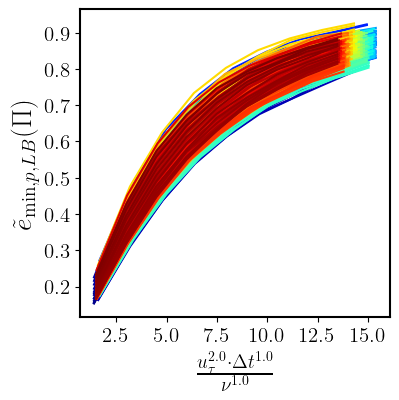

In [20]:
#Pi_t = [calc_pi(a, basis_matrices, p) for a in a_list]
#Pi_t = np.array(Pi_t).reshape(-1,1)
input_list = [calc_pi_omega(np.array(omega), p) for omega in normalized_coef_pi_list]
Pi_t       = np.column_stack(input_list)

unique_labels = np.unique(label_vector)
colors        = plt.cm.jet(np.linspace(0, 1, len(unique_labels)))
color_map     = {label: colors[i] for i, label in enumerate(unique_labels)}

plt.figure(figsize=(4, 4))
plt.rcParams['font.family'] = 'Times New Roman'  # Set the font to Times New Roman
plt.rcParams['text.usetex'] = True  # Use LaTeX for all text rendering

# Scatter plot with color coding based on labels
for label in unique_labels:
    idx = label_vector == label
    plt.plot(Pi_t[idx], q[idx], color=color_map[label], label=f'Label {label}')

# Customize the axes labels
plt.ylabel(r'$\tilde{e}_{\min , p, L B}(\Pi)$', fontsize=20)
plt.xlabel(p_lab[0], fontsize=20)

# Set tick labels' font size
plt.xticks(fontsize=15)
plt.yticks(fontsize=15)

# Adjust line thickness for the plot spines
plt.gca().spines['top'].set_linewidth(1.5)
plt.gca().spines['bottom'].set_linewidth(1.5)
plt.gca().spines['left'].set_linewidth(1.5)
plt.gca().spines['right'].set_linewidth(1.5)

# Save the plot as a high-quality PNG and EPS
plt.savefig('performance_dimensionless.png', dpi=300, bbox_inches='tight')
plt.savefig('performance_dimensionless.eps', dpi=300, bbox_inches='tight')

# Show the plot
plt.show()